## Code 

In [187]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import time
import math
import re
import gc
import random
from tensorboardX import SummaryWriter
from matplotlib import pyplot as plt
import numpy as np
randn = np.random.randn
from pandas import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rezka/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'test', 'plotting', 'normal', 'datetime', 'clip', 'f', 'unique']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [188]:
def randomize_data(inps, labels):
    even_ind = np.arange(0,len(inps),2)
    odd_ind = np.arange(1,len(inps),2)
    assert len(even_ind) == len(odd_ind)
    random.shuffle(even_ind)
    random.shuffle(odd_ind)
    shuffled_index = np.array([val for pair in zip(even_ind, odd_ind) for val in pair])
    return np.array(inps)[shuffled_index].tolist(), np.array(labels)[shuffled_index].tolist()

def randomize_data_odd(inps, labels):
    #even_ind = np.arange(0,len(inps),2)
    odd_ind = np.arange(1,len(inps),2)
    #assert len(even_ind) == len(odd_ind)
    #random.shuffle(even_ind)
    random.shuffle(odd_ind)
    shuffled_index = np.array(odd_ind)
    return np.array(inps)[shuffled_index].tolist(), np.array(labels)[shuffled_index].tolist()

def randomize_data_ev(inps, labels):
    even_ind = np.arange(0,len(inps),2)
    #odd_ind = np.arange(1,len(inps),2)
    #assert len(even_ind) == len(odd_ind)
    random.shuffle(even_ind)
    #random.shuffle(odd_ind)
    shuffled_index = np.array(even_ind)
    return np.array(inps)[shuffled_index].tolist(), np.array(labels)[shuffled_index].tolist()

In [189]:
# generate data
inps_t = []
labels_t = []
with open("./dataset/non-overlap/subreg_test_10000_non.txt", "r") as f:
    for line in f:
        ar = line.split("\t")
        g_str = ar[0].replace(" ","#")
        inp = g_str + "$" + ar[1] 
        lab = ar[2].replace("\n","")
        inps_t.append(inp)
        labels_t.append(lab)
inps_t, labels_t = randomize_data(inps_t, labels_t)
inps_to, labels_to = randomize_data_odd(inps_t, labels_t)
inps_te, labels_te = randomize_data_ev(inps_t, labels_t)

inps_v = []
labels_v = []
with open("./dataset/non-overlap/subreg_valid_10000_non.txt", "r") as f:
    for line in f:
        ar = line.split("\t")
        g_str = ar[0].replace(" ","#")
        inp = g_str + "$" + ar[1] 
        lab = ar[2].replace("\n","")
        inps_v.append(inp)
        labels_v.append(lab)
inps_v, labels_v = randomize_data(inps_v, labels_v)
inps_vo, labels_vo = randomize_data_odd(inps_v, labels_v)
inps_ve, labels_ve = randomize_data_ev(inps_v, labels_v)


inps = []
labels = []
with open("./dataset/non-overlap/subreg_train_10000_non.txt", "r") as f:
    for line in f:
        ar = line.split("\t")
        g_str = ar[0].replace(" ","#")
        inp = g_str + "$" + ar[1] 
        lab = ar[2].replace("\n","")
        inps.append(inp)
        labels.append(lab)
inps, labels = randomize_data(inps, labels)

In [190]:
# in this case it is only six
all_characters = ['a','b','c','d','e','f','#','$']
n_letters = 8
categ = ['0', '1']
n_categories = 2
len_example = 40 # length of the grammars and example

# turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(n_letters).long()
    char_index = all_characters.index(string)
    tensor[char_index] = 1
    return tensor

def categories_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for li, letter in enumerate(string):
        letter_index = categ.index(letter)
        tensor[li] = letter_index
    return tensor

def seq_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for li, letter in enumerate(string):
        letter_index = all_characters.index(letter)
        tensor[li] = letter_index
    return tensor

In [191]:
def generate_batch(start_index, len_example, batch_size, inps, labels):
    inp_tensor = torch.zeros(batch_size, len_example).long()
    lab_tensor = torch.zeros(batch_size, 1).long()
    for i in range(batch_size):
        inp = seq_tensor(inps[start_index+i])
        lab = categories_tensor(labels[start_index+i])
        inp_tensor[i,:] = inp
        lab_tensor[i,:] = lab
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor, requires_grad=False).cuda(), Variable(lab_tensor, requires_grad=False).cuda()

In [192]:
def generate_random_batch(len_example, batch_size, inps, labels):
    even_ind = np.arange(0,len(inps),2)
    odd_ind = np.arange(1,len(inps),2)
    a = random.choice(even_ind, batch_size // 2)
    b = random.choice(odd_ind, batch_size // 2)
    random_index = np.concatenate([a,b])
    inp_tensor = torch.zeros(batch_size, len_example).long()
    lab_tensor = torch.zeros(batch_size, 1).long()
    for i, ind in enumerate(random_index):
        inp = seq_tensor(inps[ind])
        lab = categories_tensor(labels[ind])
        inp_tensor[i,:] = inp
        lab_tensor[i,:] = lab
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor, requires_grad=False).cuda(), Variable(lab_tensor, requires_grad=False).cuda()

In [193]:
def convert_string(texts):
    inp_tensor = torch.zeros(1, len_example).long()
    inp = seq_tensor(texts)
    inp_tensor[0,:] = inp
    # uncomment to do this with CPU
    #return Variable(inp_tensor), Variable(lab_tensor)
    return Variable(inp_tensor, requires_grad=False).cuda()

In [194]:
# hyperparameters
n_epochs = 40
n_hidden = 256
n_layers = 2
lr = 1e-3
clip = 0.25
batch_size = 100
dropout = 0.2
grammar_len = 20
n_k_factors = 5

print_every = 200

In [195]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=2, dropout_p=0.2, 
                 grammar_len=15, n_k_factors=5):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout
        self.input_dropout = nn.Dropout(p=dropout_p)
        self.embed = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(2*hidden_size, hidden_size, n_layers, dropout=dropout_p, batch_first=True)
        self.output = nn.Linear(hidden_size, output_size)
        self.n_k_factors = n_k_factors
        self.grammar_len = grammar_len
        
        # for context-attended output
        self.linear_out = nn.Linear(hidden_size*2, hidden_size)
        # for mapping to probability
        self.linear_ponder = nn.Linear(hidden_size, 1)
        self.ponder_noise = nn.Embedding(n_k_factors,  hidden_size)
    
    def forward(self, input, hidden, batch_size, attn=False, context=None, prev_ht=None, ponder=False):
        embedded = self.embed(input) # [batch_size, seq_len, embed_size]
        embedded = self.input_dropout(embedded)
        inp_embedded = embedded
        output = None
        # for visualization #
        vis_attn = Variable(torch.zeros(self.n_k_factors, batch_size, 1
                                               , self.grammar_len)).cuda()
        
        if not attn:
            seq_len = embedded.size(1) 
            prev_ht = self.init_prev_ht(batch_size, seq_len)
            embedded = torch.cat((embedded, prev_ht), dim=2)
            ht, hidden = self.lstm(embedded, hidden) # [batch_size, seq_len, hidden_size]
            output = self.output(ht.squeeze(1))
        else:
            ### pondering step ###
            if ponder:
                pondered_ht = Variable(torch.zeros(self.n_k_factors, batch_size, 1, self.hidden_size)).cuda()
                pondered_prob_ht = Variable(torch.zeros(self.n_k_factors, batch_size, 1, 1)).cuda()
                pondered_hidden = Variable(torch.zeros(self.n_k_factors, self.n_layers, batch_size
                                                       , self.hidden_size)).cuda()
                pondered_cell = Variable(torch.zeros(self.n_k_factors, self.n_layers, batch_size
                                                       , self.hidden_size)).cuda()
                # for testing #
#                 noise = Variable((0) * torch.ones(batch_size, 1).long()).cuda()
#                 noise_embed = self.ponder_noise(noise) # [batch_size, 1, n_hidden]
#                 embedded = torch.add(inp_embedded, noise_embed)
#                 embedded = torch.cat((embedded, prev_ht), dim=2)
#                 ht, fixed_hidden = self.lstm(embedded, hidden)
#                 prob_ht = self.linear_ponder(ht)
#                 # calulate N attn
#                 attn = torch.bmm(ht, context.transpose(1,2))
#                 attn = F.softmax(attn.view(-1, self.grammar_len), dim=1).view(batch_size, -1, grammar_len)

#                 # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
#                 mix = torch.bmm(attn, context)

#                 # concat -> (batch, out_len, 2*dim)
#                 combined = torch.cat((mix, ht), dim=2)
#                 # output -> (batch, out_len, dim)
#                 ht = F.tanh(self.linear_out(combined.view(-1, 2 * self.hidden_size))).view(
#                     batch_size, -1, self.hidden_size)
#                 # gather the pondered hidden states and its probability
#                 pondered_ht[0] = ht
#                 pondered_prob_ht[0] = prob_ht
#                 pondered_hidden[0] = fixed_hidden[0]
#                 pondered_cell[0] = fixed_hidden[1]
#                 vis_attn[0] = attn
                
                
                for c in range(0, self.n_k_factors):
                    noise = Variable((c) * torch.ones(batch_size, 1).long()).cuda()
                    noise_embed = self.ponder_noise(noise) # [batch_size, 1, n_hidden]
                    embedded = torch.add(inp_embedded, noise_embed)
                    embedded = torch.cat((embedded, prev_ht), dim=2)
                    ht, hidden = self.lstm(embedded, hidden)
                    prob_ht = self.linear_ponder(ht)
                    # calulate N attn
                    attn = torch.bmm(ht, context.transpose(1,2))
                    attn = F.softmax(attn.view(-1, self.grammar_len), dim=1).view(batch_size, -1, grammar_len)

                    # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
                    mix = torch.bmm(attn, context)

                    # concat -> (batch, out_len, 2*dim)
                    combined = torch.cat((mix, ht), dim=2)
                    # output -> (batch, out_len, dim)
                    ht = F.tanh(self.linear_out(combined.view(-1, 2 * self.hidden_size))).view(
                        batch_size, -1, self.hidden_size)
                    # gather the pondered hidden states and its probability
                    pondered_ht[c] = ht
                    pondered_prob_ht[c] = prob_ht
                    pondered_hidden[c] = hidden[0]
                    pondered_cell[c] = hidden[1]
                    vis_attn[c] = attn
                    
                pondered_prob_ht = F.softmax(pondered_prob_ht, dim=0)
                ht = torch.mul(pondered_ht, pondered_prob_ht)
                ht = ht.sum(0).view(batch_size, 1, -1)
                pondered_prob_hid = pondered_prob_ht.view(self.n_k_factors, 1, batch_size, 1)
                hid = torch.mul(pondered_hidden, pondered_prob_hid)
                hid = hid.sum(0).view(self.n_layers, batch_size, -1)
                cell = torch.mul(pondered_cell, pondered_prob_hid)
                cell = cell.sum(0).view(self.n_layers, batch_size, -1)
                hidden = (hid, cell)
                
            ### attention with dot mechanism Luong ###
            else:
                embedded = torch.cat((embedded, prev_ht), dim=2)
                ht, hidden = self.lstm(embedded, hidden) # [batch_size, 1, hidden_size]
                # (batch, out_len, dim) * (batch, in_len, dim) -> (batch, out_len, in_len)
                # in_len is the number of characters in total k-factors
                # out_len is the number of step which is 1
                attn = torch.bmm(ht, context.transpose(1,2))
                attn = F.softmax(attn.view(-1, self.grammar_len), dim=1).view(batch_size, -1, grammar_len)

                # (batch, out_len, in_len) * (batch, in_len, dim) -> (batch, out_len, dim)
                mix = torch.bmm(attn, context)

                # concat -> (batch, out_len, 2*dim)
                combined = torch.cat((mix, ht), dim=2)
                # output -> (batch, out_len, dim)
                ht = F.tanh(self.linear_out(combined.view(-1, 2 * self.hidden_size))).view(
                    batch_size, -1, self.hidden_size)
                vis_attn[0] = attn
                
            output = self.output(ht.squeeze(1))
            
        return output, ht, hidden, vis_attn

    def init_hidden(self, batch_size):
        h0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).cuda()
        c0 = Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)).cuda()
        return h0, c0
    
    def init_prev_ht(self, batch_size, seq_len):
        ht = Variable(torch.zeros(batch_size, seq_len, self.hidden_size)).cuda()
        return ht

In [196]:
rnn = RNN(n_letters, n_hidden, n_categories, n_layers=n_layers, 
          dropout_p=dropout, grammar_len=grammar_len, n_k_factors=n_k_factors)
rnn_optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

In [197]:
rnn.cuda()

RNN(
  (input_dropout): Dropout(p=0.2)
  (embed): Embedding(8, 256)
  (lstm): LSTM(512, 256, num_layers=2, batch_first=True, dropout=0.2)
  (output): Linear(in_features=256, out_features=2)
  (linear_out): Linear(in_features=512, out_features=256)
  (linear_ponder): Linear(in_features=256, out_features=1)
  (ponder_noise): Embedding(5, 256)
)

In [198]:
# training
def train(inp, target, attn=False, ponder=False, pool=False):
    # pool
    pool_hidden = Variable(torch.zeros(len_example - grammar_len, batch_size, 1
                                           , n_hidden)).cuda()
    
    loss = 0
    hidden = rnn.init_hidden(batch_size)
    rnn.train()
    rnn.zero_grad()
    cls = None
    if attn:
        #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
        i = 0
        output, ht, hidden, vis_attn = rnn(inp[:,:20], hidden, batch_size)
#         for j in range(ht.size(1)):
#             if j not in [3,7,11,15,19]:
#                 grammar_contexts[i] = ht[:,j,:].transpose(0,1)
#                 i += 1
        grammar_contexts = ht
        #print(grammar_contexts)
        ht = rnn.init_prev_ht(batch_size, 1)
        for c in range(len_example - 20):
            #print(ht)
            if ponder:
                output, ht, hidden, vis_attn = rnn(inp[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                     context=grammar_contexts, prev_ht=ht, ponder=True)
            else:
                output, ht, hidden, vis_attn = rnn(inp[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                     context=grammar_contexts, prev_ht=ht, ponder=False)
            pool_hidden[c] = ht
            #print(ht)
        # pool
        if pool:
            logits, _ = torch.max(pool_hidden, 0)
            cls = rnn.output(logits.squeeze(1))
        else:
            cls = output
        cls = F.softmax(cls, dim=1)
    else:
        output, ht, hidden, vis_attn = rnn(inp, hidden, batch_size)
        cls = output[:,-1,:].contiguous()
        cls = F.softmax(cls, dim=1) 
    loss = criterion(cls.view(batch_size, -1), target.squeeze(1))
    loss.backward()
    rnn_optimizer.step()

    return loss.data[0], ht, hidden

In [199]:
# batch_size = 10
# start_index = 0
# hidden = rnn.init_hidden(batch_size)
# inp, target = generate_batch(start_index, len_example, batch_size, inps, labels)
# train(inp, target, attn=True, ponder=False, pool=True)

In [200]:
def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [201]:
def accuracy_test_data(inps_t, labels_t, attn=False, ponder=False, pool=False):
    batch_size = 200
    it = len(inps_t) / batch_size
    acc_tot = 0
    rnn.eval()
    for i in range(int(it)):
        # pool
        pool_hidden = Variable(torch.zeros(len_example - grammar_len, batch_size, 1
                                               , n_hidden)).cuda()
        cls = None
        hidden = rnn.init_hidden(batch_size)
        start_index = i * batch_size
        inp_t, lab_t = generate_batch(start_index, len_example, batch_size, inps_t, labels_t)
        
        if attn:
            #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
            i = 0
            output, ht, hidden, vis_attn = rnn(inp_t[:,:20], hidden, batch_size)
    #         for j in range(ht.size(1)):
    #             if j not in [3,7,11,15,19]:
    #                 grammar_contexts[i] = ht[:,j,:].transpose(0,1)
    #                 i += 1
            grammar_contexts = ht
            #print(grammar_contexts)
            ht = rnn.init_prev_ht(batch_size, 1)
            for c in range(len_example - 20):
                #print(ht)
                if ponder:
                    output, ht, hidden, vis_attn = rnn(inp_t[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                         context=grammar_contexts, prev_ht=ht, ponder=True)
                else:
                    output, ht, hidden, vis_attn = rnn(inp_t[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                         context=grammar_contexts, prev_ht=ht, ponder=False)
                pool_hidden[c] = ht
                #print(ht)
            # pool
            if pool:
                logits, _ = torch.max(pool_hidden, 0)
                cls = rnn.output(logits.squeeze(1))
            else:
                cls = output
            cls = F.softmax(cls, dim=1)
        else:
            output, ht, hidden, vis_attn = rnn(inp_t, hidden, batch_size)
            cls = output[:,-1,:].contiguous()
            cls = F.softmax(cls, dim=1)
            
        max_idx = cls.max(1)[1]
        accuracy = (lab_t.squeeze() == max_idx).long().sum().float() / batch_size
        acc_tot += accuracy.data[0] #, max_idx.sum().data[0]
    return acc_tot / it

In [202]:
def accuracy_train_data(attn=False, ponder=False, pool=False):
    batch_size = 200
    it = len(inps) / batch_size
    acc_tot = 0
    rnn.eval()
    for i in range(int(it)):
        # pool
        pool_hidden = Variable(torch.zeros(len_example - grammar_len, batch_size, 1
                                               , n_hidden)).cuda()
        cls = None
        hidden = rnn.init_hidden(batch_size)
        start_index = i * batch_size
        inp_t, lab_t = generate_batch(start_index, len_example, batch_size, inps, labels)
        
        if attn:
            #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
            i = 0
            output, ht, hidden, vis_attn = rnn(inp_t[:,:20], hidden, batch_size)
#             for j in range(ht.size(1)):
#                 if j not in [3,7,11,15,19]:
#                     grammar_contexts[i] = ht[:,j,:].transpose(0,1)
#                     i += 1
            grammar_contexts = ht
            #print(grammar_contexts)
            ht = rnn.init_prev_ht(batch_size, 1)
            for c in range(len_example - 20):
                #print(ht)
                if ponder:
                    output, ht, hidden, vis_attn = rnn(inp_t[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                         context=grammar_contexts, prev_ht=ht, ponder=True)
                else:
                    output, ht, hidden, vis_attn = rnn(inp_t[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                         context=grammar_contexts, prev_ht=ht, ponder=False)
                pool_hidden[c] = ht
                #print(ht)
            # pool
            if pool:
                logits, _ = torch.max(pool_hidden, 0)
                cls = rnn.output(logits.squeeze(1))
            else:
                cls = output
            cls = F.softmax(cls, dim=1)
        else:
            output, ht, hidden, vis_attn = rnn(inp_t, hidden, batch_size)
            cls = output[:,-1,:].contiguous()
            cls = F.softmax(cls, dim=1)
        
        max_idx = cls.max(1)[1]
        accuracy = (lab_t.squeeze() == max_idx).long().sum().float()
        acc_tot += accuracy.data[0] #, max_idx.sum().data[0]
    return acc_tot / len(inps)

In [68]:
import glob
res_f = glob.glob('json/lstm/winning/LSTM_*.json')
best_config = ""
max_val_seq_acc = 0
fin_res = 0
fin_res_tr = 0
fin_res_ts = 0
for fs in res_f:
    if "non" not in fs:
        with open(fs, "r") as f:
            try:
                a = json.loads(f.read())
                val_seq_acc = a['data/valid_accuracy']
                trn_seq_acc = a['data/train_accuracy']
                tst_seq_acc = a['data/test_accuracy']
            except:
                print("error " + fs)
            if "_10000_" not in fs:
                fin_res += max(sub[-1] for sub in val_seq_acc)
            #fin_res += max(sub[-1] for sub in val_seq_acc)
            fin_res_tr += max(sub[-1] for sub in trn_seq_acc)
            fin_res_ts += max(sub[-1] for sub in tst_seq_acc)
            #fin_res_ts += max(sub[-1] for sub in tst_seq_acc)
            if max_val_seq_acc < max(sub[-1] for sub in val_seq_acc):
                max_val_seq_acc = max(sub[-1] for sub in val_seq_acc)
                best_config = fs
            print(fs, max(sub[-1] for sub in val_seq_acc), max(sub[-1] for sub in tst_seq_acc))
print(fin_res_tr / 8)
print(fin_res / 7)
print(fin_res_ts / 8)
# print(max_val_seq_acc)
# print("best " + best_config)

json/lstm/winning/LSTM_500_data_500-hidden_size_64-dropout_rate_0.2-layers_lstm_2.json 0.6019999891519541 0.5947499871253961
json/lstm/winning/LSTM_1000_layers_lstm_2-hidden_size_64-dropout_rate_0.2.json 0.607249987125396 0.5987499833106991
json/lstm/winning/LSTM_50_dropout_rate_0.2-hidden_size_64-layers_lstm_2-data_50.json 0.670249983668327 0.660249981284141
json/lstm/winning/LSTM_5_layers_lstm_2-data_5-dropout_rate_0.2-hidden_size_64.json 0.9854999691247941 0.9844999670982361
json/lstm/winning/LSTM_5000_data_5000-layers_lstm_2-hidden_size_64-dropout_rate_0.2.json 0.58769998550415 0.5891999822854991
json/lstm/winning/LSTM_10_data_10-layers_lstm_2-hidden_size_64-dropout_rate_0.2.json 0.9772499620914451 0.9754999667406081
json/lstm/winning/LSTM_100_dropout_rate_0.2-data_100-layers_lstm_2-hidden_size_64.json 0.607499991357326 0.608749985694885
json/lstm/winning/LSTM_10000_dropout_rate_0.2-data_10000-layers_lstm_2-hidden_size_64.json 0.5867999899387351 0.5820499902963631
0.798547633960842

In [175]:
import glob
for_vis = []
for_vis_test = []

res_f = glob.glob('json/lstm/winning/LSTM_*.json')
start = 'LSTM_non_'
end = '_'
for fs in res_f:
    if "non" in fs:
        with open(fs, "r") as f:
            try:
                a = json.loads(f.read())
                val_seq_acc = a['data/valid_accuracy']
                trn_seq_acc = a['data/train_accuracy']
                tst_seq_acc = a['data/test_accuracy']
            except:
                print("error " + fs)
            tmp = fs[fs.find(start)+len(start):]
            for_vis.append(["lstm", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in val_seq_acc)])
            for_vis_test.append(["lstm", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in tst_seq_acc)])

res_f = glob.glob('json/lstm+attn/winning/LSTM_*.json')
start = 'LSTM_attn_non_'
end = '_'
for fs in res_f:
    if "non" in fs:
        with open(fs, "r") as f:
            try:
                a = json.loads(f.read())
                val_seq_acc = a['data/valid_accuracy']
                trn_seq_acc = a['data/train_accuracy']
                tst_seq_acc = a['data/test_accuracy']
            except:
                print("error " + fs)
            tmp = fs[fs.find(start)+len(start):]
            for_vis.append(["lstm+attn", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in val_seq_acc)])
            for_vis_test.append(["lstm+attn", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in tst_seq_acc)])

res_f = glob.glob('json/lstm+attn+act/winning/LSTM_*.json')
start = 'LSTM_attn_act_non_'
end = '_'
for fs in res_f:
    if "non" in fs:
        with open(fs, "r") as f:
            try:
                a = json.loads(f.read())
                val_seq_acc = a['data/valid_accuracy']
                trn_seq_acc = a['data/train_accuracy']
                tst_seq_acc = a['data/test_accuracy']
            except:
                print("error " + fs)
            tmp = fs[fs.find(start)+len(start):]
            for_vis.append(["lstm+attn+act", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in val_seq_acc)])
            for_vis_test.append(["lstm+attn+act", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in tst_seq_acc)])

# print(for_vis)
# print()
# print(max_val_seq_acc)
# print("best " + best_config)

In [176]:
import glob
for_vis2 = []
for_vis2_test = []

res_f = glob.glob('json/lstm/winning/LSTM_*.json')
start = 'LSTM_'
end = '_'
for fs in res_f:
    if "_non_" not in fs:
        with open(fs, "r") as f:
            try:
                a = json.loads(f.read())
                val_seq_acc = a['data/valid_accuracy']
                trn_seq_acc = a['data/train_accuracy']
                tst_seq_acc = a['data/test_accuracy']
            except:
                print("error " + fs)
#             if "_10000_" not in fs:
#                 fin_res += max(sub[-1] for sub in val_seq_acc)
            tmp = fs[fs.find(start)+len(start):]
            if "_10000_" not in fs:
                for_vis2.append(["lstm", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in val_seq_acc)])
            else:
                for_vis2.append(["lstm", int(tmp[:tmp.find(end)]), 0])
            for_vis2_test.append(["lstm", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in tst_seq_acc)])

res_f = glob.glob('json/lstm+attn/winning/LSTM_*.json')
start = 'LSTM_attn_'
end = '_'
for fs in res_f:
    if "_non_" not in fs:
        with open(fs, "r") as f:
            try:
                a = json.loads(f.read())
                val_seq_acc = a['data/valid_accuracy']
                trn_seq_acc = a['data/train_accuracy']
                tst_seq_acc = a['data/test_accuracy']
            except:
                print("error " + fs)
            tmp = fs[fs.find(start)+len(start):]
            if "_10000_" not in fs:
                for_vis2.append(["lstm+attn", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in val_seq_acc)])
            else:
                for_vis2.append(["lstm+attn", int(tmp[:tmp.find(end)]), 0])
            for_vis2_test.append(["lstm+attn", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in tst_seq_acc)])

res_f = glob.glob('json/lstm+attn+act/winning/LSTM_*.json')
start = 'LSTM_attn_act_'
end = '_'
for fs in res_f:
    if "_non_" not in fs:
        with open(fs, "r") as f:
            try:
                a = json.loads(f.read())
                val_seq_acc = a['data/valid_accuracy']
                trn_seq_acc = a['data/train_accuracy']
                tst_seq_acc = a['data/test_accuracy']
            except:
                print("error " + fs)
            tmp = fs[fs.find(start)+len(start):]
            if "_10000_" not in fs:
                for_vis2.append(["lstm+attn+act", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in val_seq_acc)])
            else:
                for_vis2.append(["lstm+attn+act", int(tmp[:tmp.find(end)]), 0])
            for_vis2_test.append(["lstm+attn+act", int(tmp[:tmp.find(end)]), max(sub[-1] for sub in tst_seq_acc)])

print(for_vis2)
print(for_vis2_test)
# print(max_val_seq_acc)
# print("best " + best_config)

[['lstm', 500, 0.6019999891519541], ['lstm', 1000, 0.607249987125396], ['lstm', 50, 0.670249983668327], ['lstm', 5, 0.9854999691247941], ['lstm', 5000, 0.58769998550415], ['lstm', 10, 0.9772499620914451], ['lstm', 100, 0.607499991357326], ['lstm', 10000, 0], ['lstm+attn', 500, 0.8757499843835831], ['lstm+attn', 10000, 0], ['lstm+attn', 100, 0.9782499670982361], ['lstm+attn', 50, 0.9719999670982361], ['lstm+attn', 10, 0.9867499738931651], ['lstm+attn', 5000, 0.595799987316131], ['lstm+attn', 1000, 0.953999984264373], ['lstm+attn', 5, 1.0], ['lstm+attn+act', 50, 0.7712499797344201], ['lstm+attn+act', 1000, 0.7094999849796291], ['lstm+attn+act', 10, 0.933749988675117], ['lstm+attn+act', 5, 0.9997500002384181], ['lstm+attn+act', 5000, 0.6509999859333031], ['lstm+attn+act', 500, 0.6849999845027921], ['lstm+attn+act', 10000, 0], ['lstm+attn+act', 100, 0.7202499866485591]]
[['lstm', 500, 0.5947499871253961], ['lstm', 1000, 0.5987499833106991], ['lstm', 50, 0.660249981284141], ['lstm', 5, 0.98

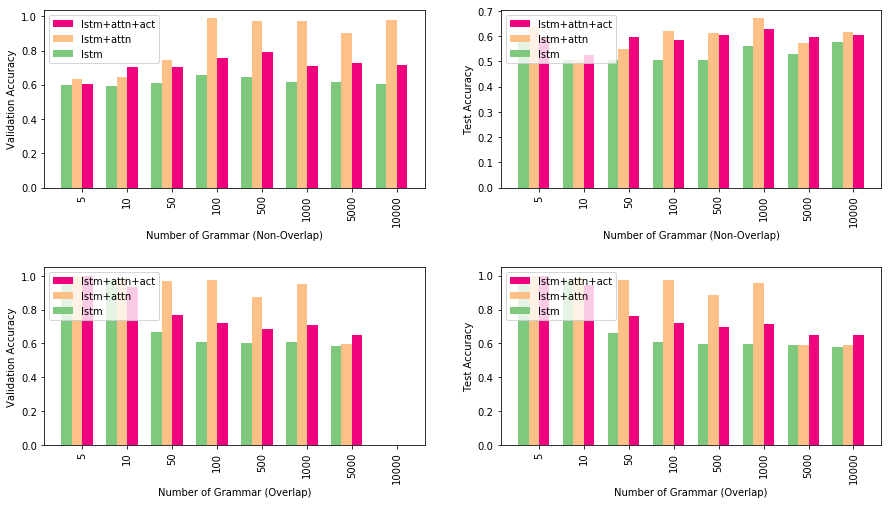

In [186]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import operator as o

import numpy as np

fig = plt.figure(figsize=(15,8))

def barplot(ax, dpoints, name, name2):
    '''
    Create a barchart for data across different categories with
    multiple conditions for each category.
    
    @param ax: The plotting axes from matplotlib.
    @param dpoints: The data set as an (n, 3) numpy array
    '''
    
    # Aggregate the conditions and the categories according to their
    # mean values
    conditions = [(c, np.mean(dpoints[dpoints[:,0] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,0])]
    categories = [(c, np.mean(dpoints[dpoints[:,1] == c][:,2].astype(float))) 
                  for c in np.unique(dpoints[:,1])]
    
    # sort the conditions, categories and data so that the bars in
    # the plot will be ordered by category and condition
    conditions = [c[0] for c in sorted(conditions, key=o.itemgetter(1))]
    categories = [c[0] for c in sorted(categories, key=o.itemgetter(0))]
    
    categ = [int(c) for c in categories]
    categories = [str(c) for c in sorted(categ)]
    conditions = ["lstm", "lstm+attn", "lstm+attn+act"]
    
    dpoints = np.array(sorted(dpoints, key=lambda x: categories.index(x[1])))

    # the space between each set of bars
    space = 0.3
    n = len(conditions)
    width = (1 - space) / (len(conditions))
    
    # Create a set of bars at each position
    for i,cond in enumerate(conditions):
        indeces = range(1, len(categories)+1)
        vals = dpoints[dpoints[:,0] == cond][:,2].astype(np.float)
        pos = [j - (1 - space) / 2. + i * width for j in indeces]
        ax.bar(pos, vals, width=width, label=cond, 
               color=cm.Accent(float(i) / n))
    
    # Set the x-axis tick labels to be equal to the categories
    ax.set_xticks(indeces)
    ax.set_xticklabels(categories)
    plt.setp(plt.xticks()[1], rotation=90)
    
    # Add the axis labels
    ax.set_ylabel(name + " Accuracy")
    ax.set_xlabel("Number of Grammar " + (name2))
    
    # Add a legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='upper left')    

ax = fig.add_subplot(221)
dpoints = np.array(for_vis)
barplot(ax, dpoints, "Validation", "(Non-Overlap)")

ax = fig.add_subplot(222)
dpoints = np.array(for_vis_test)
barplot(ax, dpoints, "Test", "(Non-Overlap)")

ax = fig.add_subplot(223)
dpoints = np.array(for_vis2)
barplot(ax, dpoints, "Validation", "(Overlap)")

ax = fig.add_subplot(224)
dpoints = np.array(for_vis2_test)
barplot(ax, dpoints, "Test", "(Overlap)")

subplots_adjust(hspace=0.45)
savefig('plots/acc_models_summarized.png')
plt.show()

In [74]:
batch_size = 200
start = time.time()
iters = 0
rnn.train(True)
losses, accs, accs_tr = [], [], []
attn = True
ponder = True
pool = True

writer = SummaryWriter()

for epoch in range(1, n_epochs + 1):
    start_index = 0
    steps = len(inps) / batch_size
    for i in range(int(steps)):
        start_index = i * batch_size
        inp, target = generate_batch(start_index, len_example, batch_size, inps, labels)
        loss, _, _ = train(inp, target, attn=attn, ponder=ponder, pool=pool)
        writer.add_scalar('data/loss', loss, iters)
        losses.append(loss)
        if iters % print_every == 0:
            acc = accuracy_test_data(inps_t, labels_t, attn=attn, ponder=ponder, pool=pool)
            acc_tr = accuracy_train_data(attn=attn, ponder=ponder, pool=pool)
            accs.append(acc)
            accs_tr.append(acc_tr)
            writer.add_scalar('data/test_accuracy', acc, iters)
            writer.add_scalar('data/train_accuracy', acc_tr, iters)
            print("Loss {}, Test Accuracy {}, Train Accuracy {}".format(loss, acc, acc_tr))
            #print("Loss {}".format(loss))

        iters += 1
acc = accuracy_test_data(inps_t, labels_t, attn=attn, ponder=ponder)
acc_tr = accuracy_train_data(attn=attn, ponder=ponder)
accs.append(acc)
accs_tr.append(acc_tr)

writer.export_scalars_to_json("./all_scalars.json")
writer.close()

Loss 0.6917438507080078, Test Accuracy 0.5, Train Accuracy 0.5


KeyboardInterrupt: 

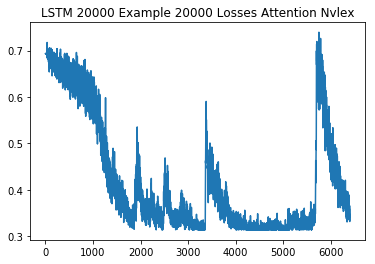

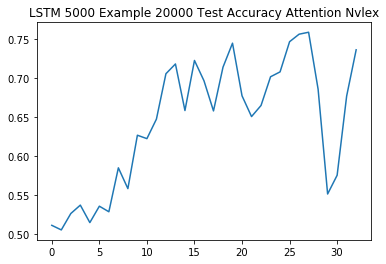

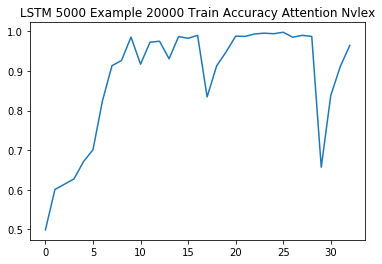

In [48]:
## plots
plt.plot(np.arange(len(losses)), losses)
plt.title('LSTM 20000 Example 20000 Losses Attention Nvlex')
plt.savefig("plots/lstm_5000example_20000c_losses_attn_nvlex_3.png")
plt.show()

plt.plot(np.arange(len(accs)), accs)
plt.title('LSTM 5000 Example 20000 Test Accuracy Attention Nvlex')
plt.savefig("plots/lstm_5000example_20000c_test_acc_attn_nvlex_3.png")
plt.show()

plt.plot(np.arange(len(accs_tr)), accs_tr)
plt.title('LSTM 5000 Example 20000 Train Accuracy Attention Nvlex')
plt.savefig("plots/lstm_5000example_20000c_train_acc_attn_nvlex_3.png")
plt.show()

In [49]:
with open('models/lstm_5000example_20000c_attn_nvlex_3.tar','wb') as ckpt:
     torch.save(rnn, ckpt)

/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:158: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [203]:
torch.nn.Module.dump_patches = True
#rnn = torch.load('models/lstm_10000example_20000c_attn_nvlex.tar').cuda()
rnn = torch.load('models/lstm+attn/LSTM_attn_non_10000_data_10000-layers_lstm_2-dropout_rate_0.2-hidden_size_256.tar').cuda()

/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.sparse.Embedding' has changed. Saved a reverse patch to Embedding.patch. Run `patch -p0 < Embedding.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.rnn.LSTM' has changed. Saved a reverse patch to LSTM.patch. Run `patch -p0 < LSTM.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)
/home/rezka/anaconda3/lib/python3.6/site-packages/torch/serialization.py:316: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. Saved a reverse patch to Linear.patch. Run `patch -p0 < Linear.patch` to revert your changes.
  warnings.warn(msg, SourceChangeWarning)


In [205]:
accuracy_test_data(inps_t, labels_t, attn=True, ponder=False, pool=False)

0.5362499803304672

In [206]:
accuracy_test_data(inps_te, labels_te, attn=True, ponder=False, pool=False)

0.970499974489212

In [207]:
accuracy_test_data(inps_to, labels_to, attn=True, ponder=False, pool=False)

0.10199999809265137

In [208]:
accuracy_test_data(inps_v, labels_v, attn=True, ponder=False, pool=False)

0.9757499635219574

In [209]:
accuracy_test_data(inps_ve, labels_ve, attn=True, ponder=False, pool=False)

0.9754999697208404

In [210]:
accuracy_test_data(inps_vo, labels_vo, attn=True, ponder=False, pool=False)

0.9759999692440033

## Visualizing Attention Mask

In [245]:
def map_index(idx):
    # 0 - 0, 1 - 4, 2 - 8, 3 - 12, 4 - 16
    return idx * 4

def map_thres(idx):
    if idx == 0:
        return 0.0
    elif idx == 1:
        return 0.0
    elif idx==2:
        return 0.5

# counting correctly attended weights #
batch_size = 1
attn=True
ponder=False
pool=False
it = len(inps_to) / batch_size
#it = 5 / batch_size
ttt, ttf, tft, tff, ftt, ftf, fft, fff = 0, 0, 0, 0, 0, 0, 0, 0
ttts, ttfs, tfts, tffs, ftts, ftfs, ffts, fffs = [], [], [], [], [], [], [], []
failed_set = []
attn_avg_tctp = []
attn_avg_tcfp = []
attn_avg_fctp = []
attn_avg_fcfp = []
for j in range(int(it)):
    # pool
    pool_hidden = Variable(torch.zeros(len_example - grammar_len, batch_size, 1
                                           , n_hidden)).cuda()
    start_index = j * batch_size
    ### check where is the index of k-factors ###
    grammar, target_str = inps_vo[start_index].split("$")
    kfs = grammar.split("#")
    idxs_check = []
    for k, kfs in enumerate(kfs):
        if kfs in target_str:
            start_kf = map_index(k)
            start_ts = target_str.find(kfs)
            idxs_check.append((start_kf, start_ts))
    
    ### gather the attention mask ###
    hidden = rnn.init_hidden(batch_size)
    inp_t, lab_t = generate_batch(start_index, len_example, batch_size, inps_to, labels_to)
    attn_vals = []
    prediction_at_step = []
    if attn:
        #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
        output, ht, hidden, vis_attn = rnn(inp_t[:,:20], hidden, batch_size)
    #         for j in range(ht.size(1)):
    #             if j not in [3,7,11,15,19]:
    #                 grammar_contexts[i] = ht[:,j,:].transpose(0,1)
    #                 i += 1
        grammar_contexts = ht
        #print(grammar_contexts)
        ht = rnn.init_prev_ht(batch_size, 1)
        for c in range(len_example - 20):
            attn_val = []
            #print(ht)
            if ponder:
                output, ht, hidden, vis_attn = rnn(inp_t[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                     context=grammar_contexts, prev_ht=ht, ponder=True)
                for i, elem in enumerate(vis_attn[3].squeeze().data):
                    attn_val.append(elem)
            else:
                output, ht, hidden, vis_attn = rnn(inp_t[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                     context=grammar_contexts, prev_ht=ht, ponder=False)
                for i, elem in enumerate(vis_attn[0].squeeze().data):
                    attn_val.append(elem)
            pool_hidden[c] = ht
            attn_vals.append(attn_val)
            prediction_at_step.append(list(F.softmax(rnn.output(ht.squeeze(1)),dim=1).data[0]))
        # pool
        if pool:
            logits, _ = torch.max(pool_hidden, 0)
            cls = rnn.output(logits.squeeze(1))
        else:
            cls = output
        cls = F.softmax(cls, dim=1)
        #print(list(cls.data))
        
        ### define hypothesis ###
        correct_attended = False
        predicted_correct = False
        hm_times = 0
        hm_cor = False
        put_ca = False
        put_pc = False
        attn_avg = []
        attn_avg_ext = []
        final_prediction = np.argmax(cls.data) == 0
        for idx_check in idxs_check:
            # 0 : index of k factors, 1 : index of target string
            #print(idx_check)
            hm_times = 0
            hm_cor = False
            # a is number of step
            for a in range(3):
                if a == 2 and np.argmax(prediction_at_step[idx_check[1]+a]) == 0:
                    predicted_correct = True
                    put_pc = True
                # b is a number of grammar
                for b in range(3):
                    attn_avg.append(attn_vals[idx_check[1]+a][idx_check[0]+b])
                    if attn_vals[idx_check[1]+a][idx_check[0]+b] > map_thres(a):
                        hm_cor = True
                if hm_cor:
                    hm_times += 1
                hm_cor = False
            if hm_times == 3:
                correct_attended = True
                put_ca = True
            for a in range(3,6):
                for b in range(0,3):
                    if idx_check[1] + a <= 19:
                        attn_avg.append(attn_vals[idx_check[1]+a][idx_check[0]+b])
                    else:
                        attn_avg.append(0.0)
            if final_prediction and put_pc:
                attn_avg_tctp.append(attn_avg)
            elif final_prediction and not put_pc:
                attn_avg_tcfp.append(attn_avg)
            elif not final_prediction and put_pc:
                attn_avg_fctp.append(attn_avg)
            elif not final_prediction and not put_pc:
                attn_avg_fcfp.append(attn_avg)
            put_ca = False
            put_pc = False
            attn_avg = []
        #print("Correctly Attended to Corresponding K-Factor {}".format(str(correct_attended)))
        #print("Predicted Correct when Attending to K-Factor {}".format(str(predicted_correct)))
        #print("Final Prediction {}".format(str(final_prediction)))
        if correct_attended and predicted_correct and final_prediction:
            ttt += 1
        elif correct_attended and predicted_correct and not final_prediction:
            ttf += 1
        elif correct_attended and not predicted_correct and final_prediction:
            tft += 1
        elif correct_attended and not predicted_correct and not final_prediction:
            tff += 1
        elif not correct_attended and predicted_correct and final_prediction:
            ftt += 1
        elif not correct_attended and predicted_correct and not final_prediction:
            ftf += 1
        elif not correct_attended and not predicted_correct and final_prediction:
            fft += 1
        elif not correct_attended and not predicted_correct and not final_prediction:
            fff += 1
        if not final_prediction:
            failed_set.append(inps_to[start_index])
            
    else:
        output, ht, hidden = rnn(inp, hidden, batch_size)
        cls = output[:,-1,:].contiguous()
        cls = F.softmax(cls, dim=1) 
    
### visualizing ###
#     ts = inps_to[start_index]
#     av = np.transpose(attn_vals)
#     idx = Index(list(ts[:20]))
#     df = DataFrame(av, index=idx, columns=list(ts[20:]))
#     vals = np.around(df.values,4)
#     normal = plt.Normalize(vals.min()-1, vals.max()+1)

#     fig = plt.figure(figsize=(15,8))
#     ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

#     tab1=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
#                         colWidths = [0.05]*vals.shape[1], loc='bottom', 
#                         cellColours=plt.cm.hot(normal(vals)))

#     idx = Index(["0", "1"])
#     df = DataFrame(np.transpose(prediction_at_step), index=idx, columns=list(ts[20:]))
#     vals = np.around(df.values,4)
#     normal = plt.Normalize(vals.min()-1, vals.max()+1)

#     fig = plt.figure(figsize=(15,8))
#     ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

#     tab2=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
#                         colWidths = [0.05]*vals.shape[1], loc='top', 
#                         cellColours=plt.cm.hot(normal(vals)))

In [246]:
print(len(attn_avg_tctp), len(attn_avg_tcfp), len(attn_avg_fctp), len(attn_avg_fcfp))

89 149 52 1993


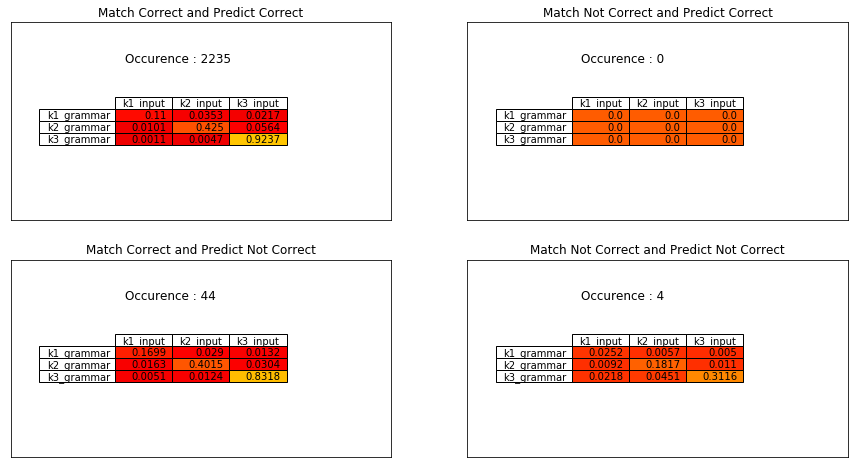

In [244]:
attn_1 = np.array(attn_avg_tctp)
attn_1_n = np.mean(attn_1[:,:9], axis=0).reshape(3,3)
attn_1_ext = np.mean(attn_1[:,9:], axis=0).reshape(3,3)
attn_2 = np.array(attn_avg_tcfp)
attn_2_n = np.mean(attn_2[:,:9], axis=0).reshape(3,3)
attn_2_ext = np.mean(attn_2[:,9:], axis=0).reshape(3,3)
# attn_2_n = np.zeros([3,3])
attn_3 = np.array(attn_avg_fctp)
attn_3_n = np.mean(attn_3[:,:9], axis=0).reshape(3,3)
attn_3_ext = np.mean(attn_3[:,9:], axis=0).reshape(3,3)
attn_4 = np.array(attn_avg_fcfp)
attn_4_n = np.mean(attn_4[:,:9], axis=0).reshape(3,3)
attn_4_ext = np.mean(attn_4[:,9:], axis=0).reshape(3,3)

idx = Index(['k1_grammar','k2_grammar','k3_grammar'])
df = DataFrame(attn_1_n, index=idx, 
               columns=['k1_input','k2_input','k3_input'])
vals = np.around(df.values,4)
normal = plt.Normalize(vals.min()-1, vals.max()+1)

fig = plt.figure(figsize=(15,8))

ax = fig.add_subplot(221, frameon=True, xticks=[], yticks=[], title="Match Correct and Predict Correct")
tab1=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.15]*vals.shape[1], loc='center', 
                    cellColours=plt.cm.hot(normal(vals)))
text(0.3, 0.8, "Occurence : " + str(len(attn_avg_tctp)), fontsize=12)

idx = Index(['k1_grammar','k2_grammar','k3_grammar'])
df = DataFrame(attn_2_n, index=idx, 
               columns=['k1_input','k2_input','k3_input'])
vals = np.around(df.values,4)
normal = plt.Normalize(vals.min()-1, vals.max()+1)

ax = fig.add_subplot(222, frameon=True, xticks=[], yticks=[], title="Match Not Correct and Predict Correct")
tab2=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.15]*vals.shape[1], loc='center', 
                    cellColours=plt.cm.hot(normal(vals)))
text(0.3, 0.8, "Occurence : " + str(len(attn_avg_tcfp)), fontsize=12)

idx = Index(['k1_grammar','k2_grammar','k3_grammar'])
df = DataFrame(attn_3_n, index=idx, 
               columns=['k1_input','k2_input','k3_input'])
vals = np.around(df.values,4)
normal = plt.Normalize(vals.min()-1, vals.max()+1)

ax = fig.add_subplot(223, frameon=True, xticks=[], yticks=[], title="Match Correct and Predict Not Correct")
tab3=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.15]*vals.shape[1], loc='center', 
                    cellColours=plt.cm.hot(normal(vals)))
text(0.3, 0.8, "Occurence : " + str(len(attn_avg_fctp)), fontsize=12)

idx = Index(['k1_grammar','k2_grammar','k3_grammar'])
df = DataFrame(attn_4_n, index=idx, 
               columns=['k1_input','k2_input','k3_input'])
vals = np.around(df.values,4)
normal = plt.Normalize(vals.min()-1, vals.max()+1)

ax = fig.add_subplot(224, frameon=True, xticks=[], yticks=[], title="Match Not Correct and Predict Not Correct")
tab4=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.15]*vals.shape[1], loc='center', 
                    cellColours=plt.cm.hot(normal(vals)))
text(0.3, 0.8, "Occurence : " + str(len(attn_avg_fcfp)), fontsize=12)
savefig("plots/attn_avg_test")

In [214]:
actdo = accuracy_test_data(inps_to, labels_to, attn=True, ponder=False)
actde = accuracy_test_data(inps_te, labels_te, attn=True, ponder=False)
actd = accuracy_test_data(inps_t, labels_t, attn=True, ponder=False)

In [215]:
print("Final Test Accuracy : {}".format(str(actd)))
print("Final Test Accuracy (Case of Reject Language / K-Factor Present) : {}".format(str(actdo)))
print("Final Test Accuracy (Case of Accept Language / K-Factor not Present) : {}".format(str(actde)))
print("### Analysis on Case of Reject Language ###")
print("Attend Correctly, Predict Correctly while Attend, Correct Final Prediction : {}".format(str(float(ttt) / len(inps_to))))
print("Attend Correctly, Predict Correctly while Attend, Wrong Final Prediction : {}".format(str(float(ttf) / len(inps_to))))
print("Attend Correctly, Predict Wrongly while Attend, Correct Final Prediction : {}".format(str(float(tft) / len(inps_to))))
print("Attend Correctly, Predict Wrongly while Attend, Wrong Final Prediction : {}".format(str(float(tff) / len(inps_to))))
print("Attend Wrongly, Predict Correctly while Attend, Correct Final Prediction : {}".format(str(float(ftt) / len(inps_to))))
print("Attend Wrongly, Predict Correctly while Attend, Wrong Final Prediction : {}".format(str(float(ftf) / len(inps_to))))
print("Attend Wrongly, Predict Wrongly while Attend, Correct Final Prediction : {}".format(str(float(fft) / len(inps_to))))
print("Attend Wrongly, Predict Wrongly while Attend, Wrong Final Prediction : {}".format(str(float(fff) / len(inps_to))))

Final Test Accuracy : 0.5362499803304672
Final Test Accuracy (Case of Reject Language / K-Factor Present) : 0.10199999809265137
Final Test Accuracy (Case of Accept Language / K-Factor not Present) : 0.970499974489212
### Analysis on Case of Reject Language ###
Attend Correctly, Predict Correctly while Attend, Correct Final Prediction : 0.0345
Attend Correctly, Predict Correctly while Attend, Wrong Final Prediction : 0.0905
Attend Correctly, Predict Wrongly while Attend, Correct Final Prediction : 0.01
Attend Correctly, Predict Wrongly while Attend, Wrong Final Prediction : 0.158
Attend Wrongly, Predict Correctly while Attend, Correct Final Prediction : 0.0285
Attend Wrongly, Predict Correctly while Attend, Wrong Final Prediction : 0.0445
Attend Wrongly, Predict Wrongly while Attend, Correct Final Prediction : 0.029
Attend Wrongly, Predict Wrongly while Attend, Wrong Final Prediction : 0.605


In [171]:
# chose an example #
inpz = inps_v
labz = labels_v

start_index = 1000
batch_size = 20
it = len(inpz) / batch_size
acc_tot = 0
cls = None
hidden = rnn.init_hidden(batch_size)
inp, lab = generate_batch(start_index, len_example, batch_size, inpz, labz)
attn=True
ponder=False
rnn.eval()
rnn.zero_grad()

if attn:
    #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
    i = 0
    output, ht, hidden, vis_attn = rnn(inp[:,:20], hidden, batch_size)
#         for j in range(ht.size(1)):
#             if j not in [3,7,11,15,19]:
#                 grammar_contexts[i] = ht[:,j,:].transpose(0,1)
#                 i += 1
    grammar_contexts = ht
    #print(grammar_contexts)
    ht = rnn.init_prev_ht(batch_size, 1)
    for c in range(len_example - 20):
        #print(ht)
        if ponder:
            output, ht, hidden, vis_attn = rnn(inp[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                 context=grammar_contexts, prev_ht=ht, ponder=True)
        else:
            output, ht, hidden, vis_attn = rnn(inp[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                 context=grammar_contexts, prev_ht=ht, ponder=False)
        #print(ht)
    cls = output
    cls = F.softmax(cls, dim=1)
else:
    output, ht, hidden = rnn(inp, hidden, batch_size)
    cls = output[:,-1,:].contiguous()
    cls = F.softmax(cls, dim=1)

max_idx = cls.max(1)[1]
for i in range(batch_size):
    print(inpz[start_index+i], max_idx.data[i], lab.squeeze().data[i])
accuracy = (lab.squeeze() == max_idx).long().sum().float()

aaa#abe#ace#bbe#bff$acbafeeccddbedbcfccc 1 1
aaa#abe#ace#bbe#bff$abceadfbbbacebaebfaa 1 0
aaa#abe#ace#bbe#bff$bddeedcaafdccbabdacf 1 1
aaa#ace#bbe#bff#cdd$fbdadfafdcedbfabffda 1 0
aaa#ace#bbe#bff#cdd$aeaabbbfcbfbbdbacabb 1 1
aaa#abe#ace#bff#cdd$ccdbdacebbaabbcbfdbc 1 0
aaa#ace#bbe#bff#cdd$ffdeacabddaecfbaecce 0 1
aaa#abe#ace#bff#cdd$eabaebceafdcddefafaa 1 0
aaa#ace#bbe#bff#cdd$ccfeeeabcdfaabdadeea 1 1
aaa#ace#bbe#bff#cdd$dccbfbdbdcddcdfaaeff 0 0
aaa#abe#ace#bff#cdd$fecdafdbfbccdaafbfac 1 1
aaa#abe#ace#bff#cdd$cddfaecedcaecbedbebc 1 0
abe#ace#bbe#bff#cdd$afeadddfbfbaaffafddc 1 1
aaa#abe#ace#bff#cdd$eceeeacabcaaafbcdfed 1 0
aaa#abe#ace#bff#cdd$dbfdabccebddcebebced 1 1
aaa#abe#bbe#bff#cdd$caeffabbabeccbadeaeb 1 0
aaa#abe#ace#bff#cdd$ebdeeaaccedddecdaaec 1 1
aaa#abe#ace#bbe#cdd$dcbedacbfbeabacecacc 1 0
aaa#abe#bbe#bff#cdd$fcaecedadfecdefadead 1 1
aaa#abe#ace#bbe#cdd$baceddcaedbfbebaafcf 1 0


In [253]:
# picking examples #
ts = "bcc#cce#dee#def#eee$fbceddbbffcebcbfedee" # label = 0
ex = convert_string(ts)
batch_size = 1
hidden = rnn.init_hidden(batch_size)
attn_vals = []
prediction_at_step = []
ponder=False
rnn.eval()
if attn:
    #grammar_contexts = torch.zeros(grammar_len, batch_size, n_hidden)
    i = 0
    output, ht, hidden, vis_attn = rnn(ex[:,:20], hidden, batch_size)
#         for j in range(ht.size(1)):
#             if j not in [3,7,11,15,19]:
#                 grammar_contexts[i] = ht[:,j,:].transpose(0,1)
#                 i += 1
    grammar_contexts = ht
    #print(grammar_contexts)
    ht = rnn.init_prev_ht(batch_size, 1)
    for c in range(len_example - 20):
        attn_val = []
        #print(ht)
        if ponder:
            output, ht, hidden, vis_attn = rnn(ex[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                 context=grammar_contexts, prev_ht=ht, ponder=True)
            for i, elem in enumerate(vis_attn[0].squeeze().data):
                attn_val.append(elem)
        else:
            output, ht, hidden, vis_attn = rnn(ex[:,20+c].unsqueeze(1), hidden, batch_size, attn=True, 
                                 context=grammar_contexts, prev_ht=ht, ponder=False)
            for i, elem in enumerate(vis_attn[0].squeeze().data):
                attn_val.append(elem)
        attn_vals.append(attn_val)
        prediction_at_step.append(list(F.softmax(rnn.output(ht.squeeze(1)),dim=1).data[0]))
    cls = output
    cls = F.softmax(cls, dim=1)
    print(list(cls.data[0]))
else:
    output, ht, hidden = rnn(inp, hidden, batch_size)
    cls = output[:,-1,:].contiguous()
    cls = F.softmax(cls, dim=1)

[1.2253041914433993e-09, 1.0]


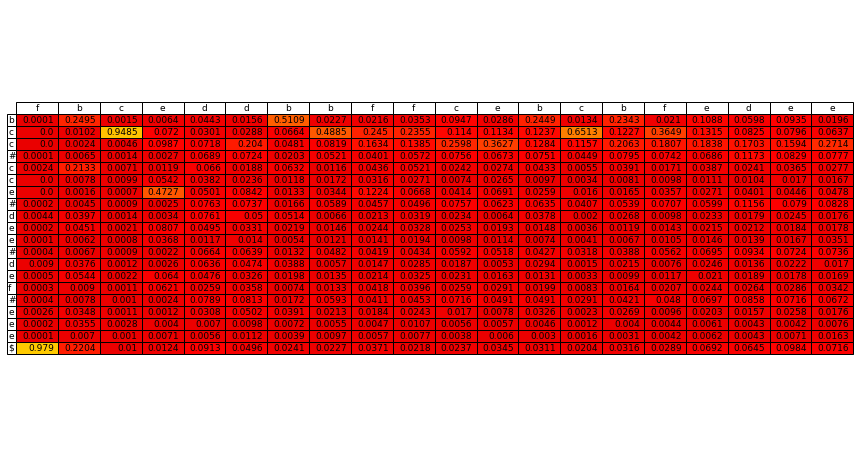

In [254]:
av = np.transpose(attn_vals)
idx = Index(list(ts[:20]))
df = DataFrame(av, index=idx, columns=list(ts[20:]))
vals = np.around(df.values,4)
normal = plt.Normalize(vals.min()-1, vals.max()+1)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, frameon=False, xticks=[], yticks=[])

tab1=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                    colWidths = [0.05]*vals.shape[1], loc='center', 
                    cellColours=plt.cm.hot(normal(vals)))

savefig("plots/examples_attn_test.png")

# idx = Index(["0", "1"])
# df = DataFrame(np.transpose(prediction_at_step), index=idx, columns=list(ts[20:]))
# vals = np.around(df.values,4)
# normal = plt.Normalize(vals.min(), vals.max())

# fig = plt.figure(figsize=(15,8))
# ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])

# tab2=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
#                     colWidths = [0.05]*vals.shape[1], loc='top', 
#                     cellColours=plt.cm.hot(normal(vals)))

## Analysis and Diagnostic Classifier

In [28]:
from sklearn import metrics
from scipy import stats
import scipy as sp

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from scipy.stats import pearsonr

import seaborn as sns

In [29]:
def hypothesis_k_factors(text):
    return np.array([-1 if x == '#' or x == '$' else 1 for x in text])

def hypothesis_detect_k_factors(text):
    hyp = np.full(len(text), -1)
    texts = text.split("$")
    kfs = texts[0].split("#")
    for kf in kfs:
        if kf in texts[1]:
            ind = [m.start() for m in re.finditer(kf, text)]
            for el in ind:
                hyp[el:el+3] = 1
    return hyp

def hypothesis_match_grammar(text):
    hyp = np.full(len(text), -1)
    texts = text.split("$")
    kfs = texts[0].split("#")
    for kf in kfs:
        if kf in texts[1]:
            ind = [m.start() for m in re.finditer(kf, text)]
            for el in ind:
                hyp[el:el+3] = 1
            for i, j in zip(range(len(kf)), reversed(range(len(kf)))):
                if j != 0:
                    ind = [m.start() for m in re.finditer(kf[:-j], text)]
                    print(ind, kf[:-j], i)
                    for el in ind:
                        hyp[el:el+i] = 1
    return hyp

In [67]:
hypothesis_match_grammar("bbb#bdd#cce#cdd#ddf$fdddcbfacddabaadfdeb")

[8, 9, 12, 24, 28] c 0
[12, 28] cd 1


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1])

In [30]:
def validate_hypothesis(model, diag_classifier, hypothesis, train_len=50,
                        test_len=1, tt=None, save_hyp=None, save_diag=None, save_resp=None):
    # Generate hypothesis data
    def gen_hyp_data(model, N, hypothesis, start_index):
        texts, hiddens, hiddens_2, hyps = [], [], [], []
        inp, target = generate_random_batch(len_example, N, inps, labels)
        for i in range(N):
            hidden, cell = rnn.init_hidden(1)
            hid = []
            hid_2 = []
            for j in range(len(inp[i])):
                _, hidden, cell = rnn(inp[i][j], hidden, cell, 1)
                hidden_temp = hidden.squeeze()
                hid.append(np.array(hidden_temp.data[0]))
                hid_2.append(np.array(hidden_temp.data[1]))
            hyp = hypothesis(inps[i])
            hiddens.append(hid)
            hiddens_2.append(hid_2)
            hyps.append(hyp)
            texts.append(inps[i])
        return ''.join(texts), np.concatenate(hyps), np.concatenate(hiddens), np.concatenate(hiddens_2)
    
    def gen_hyp_data_test(model, N, hypothesis, tt):
        texts, hiddens, hiddens_2, hyps = [], [], [], []
        tensor_tt = convert_string(tt)
        for i in range(N):
            hidden, cell = rnn.init_hidden(1)
            hid = []
            hid_2 = []
            for j in range(len(tensor_tt[i])):
                _, hidden, cell = rnn(tensor_tt[i][j], hidden, cell, 1)
                hidden_temp = hidden.squeeze()
                hid.append(np.array(hidden_temp.data[0]))
                hid_2.append(np.array(hidden_temp.data[1]))
            hyp = hypothesis(tt)
            hiddens.append(hid)
            hiddens_2.append(hid_2)
            hyps.append(hyp)
            texts.append(tt)
        return ''.join(texts), np.concatenate(hyps), np.concatenate(hiddens), np.concatenate(hiddens_2)

    # Generate train and test data
    _, train_hyps, train_hiddens, train_hiddens_2 = gen_hyp_data(model, train_len, hypothesis, 0)
    test_texts, test_hyps, test_hiddens, test_hiddens_2 = gen_hyp_data_test(model, test_len, hypothesis, tt)
    #print(pearsonr(train_hiddens, train_hyps))
    #print(pearsonr(test_hiddens, test_hyps))

    # Train Diagnostic Classifier
    diag_classifier.fit(train_hiddens, train_hyps)
    
    # Predict with Diagnostic Classifier
    pred_hyps = diag_classifier.predict(test_hiddens)
    
    # Find responsible neuron
    resp_neuron = np.argmax(np.abs(diag_classifier.coef_))
    print(resp_neuron)
    
    # Plot results
    if save_hyp:
        plot_colored_text(test_texts[:len_example], test_hyps[:len_example],
                          title='Formed Hypothesis',
                          save_file=save_hyp)
    if save_diag:
        plot_colored_text(test_texts[:len_example], pred_hyps[:len_example],
                          title='Diagnostic Classifier Prediction',
                          save_file=save_diag)
    if save_resp:
        plot_colored_text(test_texts[:len_example], test_hiddens[:len_example, resp_neuron],
                          title='Most Responsible Neuron {}'.format(resp_neuron),
                          save_file=save_resp)
        
    del(train_hyps)
    del(train_hiddens)
    del(test_texts)
    del(test_hiddens)
    gc.collect()
    
    return test_hyps, pred_hyps

In [31]:
### PLOTTING HELPERS ###
def wrap_colored_text(text, colors, W, tabsize=4):
    ''' Wrap text with hidden units to certain width '''
    new_text, new_colors = [], []

    # Wrap lines to width
    for char, color in zip(text, colors):
        if char == '\t':
            for i in range(tabsize):
                new_text.append(' ')
                new_colors.append(color)
        else:
            new_text.append(char)
            new_colors.append(color)
            if char == '\n':
                for i in range(W - len(new_text) % W):
                    new_text.append(' ')
                    new_colors.append(np.zeros_like(colors[0]))

    # Add final space to obtain (rectangular) matrix
    for i in range(W - len(new_text) % W):
        new_text.append(' ')
        new_colors.append(np.zeros_like(colors[0]))

    return np.array(new_text).reshape(-1, W), np.array(new_colors).reshape(-1, W)

def plot_colored_text(text, colors, W=80, title=None, save_file=None):
    wrapped_text, wrapped_colors = wrap_colored_text(text, colors, W, tabsize=4)

    H = len(wrapped_text)
    plt.figure(figsize=(W/5, H/3))

    color_palette = sns.color_palette("RdBu_r", 255, desat=.9)
    color_palette[127] = (1.,1.,1.) # set zero to white color
    sns.heatmap(wrapped_colors, annot=wrapped_text,
                annot_kws={'color':'black',
                           'family':'monospace',
                           'horizontalalignment':'center',
                           'fontweight':'light'},
                fmt='s', cbar=False, vmin=-2, vmax=2)
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    if save_file:
        plt.savefig(save_file)
    plt.show()

In [32]:
model_name = "lstm_2000example_20000c_attn"
hyp_name = "detect_k_factors"
y_true, y_pred = validate_hypothesis(rnn, LogisticRegression(), hypothesis_detect_k_factors,
                                         train_len=1000, test_len=1, tt="bbb#bdd#cce#cdd#ddf$fdddcbfacddabaadfdeb",
                                         save_hyp='plots/{}_hyp_{}.png'.format(model_name, hyp_name),
                                         save_diag='plots/{}_diag_{}.png'.format(model_name, hyp_name),
                                         save_resp='plots/{}_resp_{}.png'.format(model_name, hyp_name))

ValueError: not enough values to unpack (expected 2, got 0)

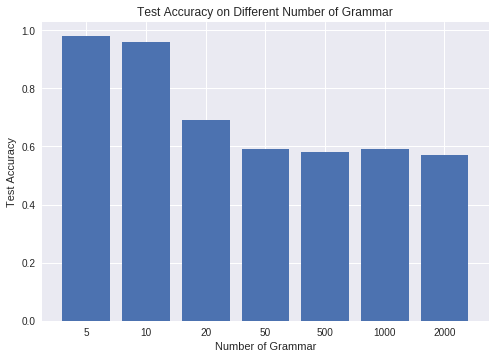

In [114]:
acc_test = [0.98, 0.96, 0.69, 0.59, 0.58, 0.59, 0.57]
experiment = [5, 10, 20, 50, 500, 1000, 2000]
x = np.arange(len(acc_test))
plt.bar(x, acc_test)
plt.xticks(x, experiment)
plt.xlabel('Number of Grammar')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy on Different Number of Grammar')
plt.savefig("plots/lstm_test_acc_bar.png")
plt.show()